<a href="https://colab.research.google.com/github/cindewarno/Asignmen1bigdata/blob/main/Cinde_Stroke_spark.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Asignment 1 Big Data

---
Title : Stroke Pedriction - SPARK Engine<br>
Nama : Cinde Warno<br>
Nik  : 2502481056


---


In [ ]:
!pip install -q pyspark

In [ ]:
# Inisialisasi Spark
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("StrokePrediction").getOrCreate()

In [ ]:
# Load dataset dari GitHub
import requests

url = "https://raw.githubusercontent.com/cindewarno/Asignmen1bigdata/bfe735f69e7f8827c48119f5e81a9ff30323d8f6/healthcare-dataset-stroke-data.csv"
response = requests.get(url)

with open("healthcare-dataset-stroke-data.csv", "w") as f:
    f.write(response.text)

df = spark.read.csv("healthcare-dataset-stroke-data.csv", header=True, inferSchema=True)
df.show()

+-----+------+----+------------+-------------+------------+-------------+--------------+-----------------+----+---------------+------+
|   id|gender| age|hypertension|heart_disease|ever_married|    work_type|Residence_type|avg_glucose_level| bmi| smoking_status|stroke|
+-----+------+----+------------+-------------+------------+-------------+--------------+-----------------+----+---------------+------+
| 9046|  Male|67.0|           0|            1|         Yes|      Private|         Urban|           228.69|36.6|formerly smoked|     1|
|51676|Female|61.0|           0|            0|         Yes|Self-employed|         Rural|           202.21| N/A|   never smoked|     1|
|31112|  Male|80.0|           0|            1|         Yes|      Private|         Rural|           105.92|32.5|   never smoked|     1|
|60182|Female|49.0|           0|            0|         Yes|      Private|         Urban|           171.23|34.4|         smokes|     1|
| 1665|Female|79.0|           1|            0|         

In [ ]:
# Preprocessing
from pyspark.sql.functions import col

df = df.dropna(subset=['bmi']).filter(df.smoking_status != 'Unknown')
df = df.withColumn("bmi", col("bmi").cast("float"))

from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler

categorical = ['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']
indexers = [StringIndexer(inputCol=c, outputCol=c+"_idx") for c in categorical]
encoders = [OneHotEncoder(inputCol=c+"_idx", outputCol=c+"_vec") for c in categorical]

assembler = VectorAssembler(
    inputCols=['age','hypertension','heart_disease','avg_glucose_level','bmi'] + [c+"_vec" for c in categorical],
    outputCol="features"
)

pipeline = Pipeline(stages=indexers + encoders + [assembler])
data = pipeline.fit(df).transform(df).select("features", col("stroke").cast("int").alias("label"))

In [ ]:
# Handle class imbalance
neg = data.filter("label == 0")
pos = data.filter("label == 1")
ratio = max(1, neg.count() // pos.count())
oversampled = pos
for _ in range(ratio - 1):
    oversampled = oversampled.union(pos)
data_bal = neg.union(oversampled)

In [ ]:
# Split
train, test = data_bal.randomSplit([0.8, 0.2], seed=42)

In [ ]:
# Train Models & Track Time
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, LinearSVC
import time

models = {
    "LogisticRegression": LogisticRegression(featuresCol="features", labelCol="label"),
    "RandomForest": RandomForestClassifier(featuresCol="features", labelCol="label", numTrees=100),
    "SVM": LinearSVC(featuresCol="features", labelCol="label", maxIter=100)
}

trained_models = {}
training_times = {}

for name, model in models.items():
    start_time = time.time()
    trained_models[name] = model.fit(train)
    end_time = time.time()
    training_times[name] = end_time - start_time


In [ ]:
# Evaluasi
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, BinaryClassificationEvaluator
import pandas as pd

eval_results = {}
for name, model in trained_models.items():
    pred = model.transform(test)
    acc = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy").evaluate(pred)
    f1 = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="f1").evaluate(pred)
    auc = BinaryClassificationEvaluator(labelCol="label", rawPredictionCol="rawPrediction", metricName="areaUnderROC").evaluate(pred)
    eval_results[name] = {
        "accuracy": acc,
        "f1": f1,
        "roc_auc": auc,
        "training_time_sec": training_times[name]
    }


In [ ]:
# Tampilkan sebagai DataFrame
df_eval = pd.DataFrame(eval_results).T.reset_index().rename(columns={"index": "Model"})
display(df_eval)

,Model,accuracy,f1,roc_auc,training_time_sec
0,LogisticRegression,0.770686,0.770674,0.844740,19.705391
1,RandomForest,0.806935,0.806339,0.886168,7.805178
2,SVM,0.772262,0.771963,0.842934,60.806201


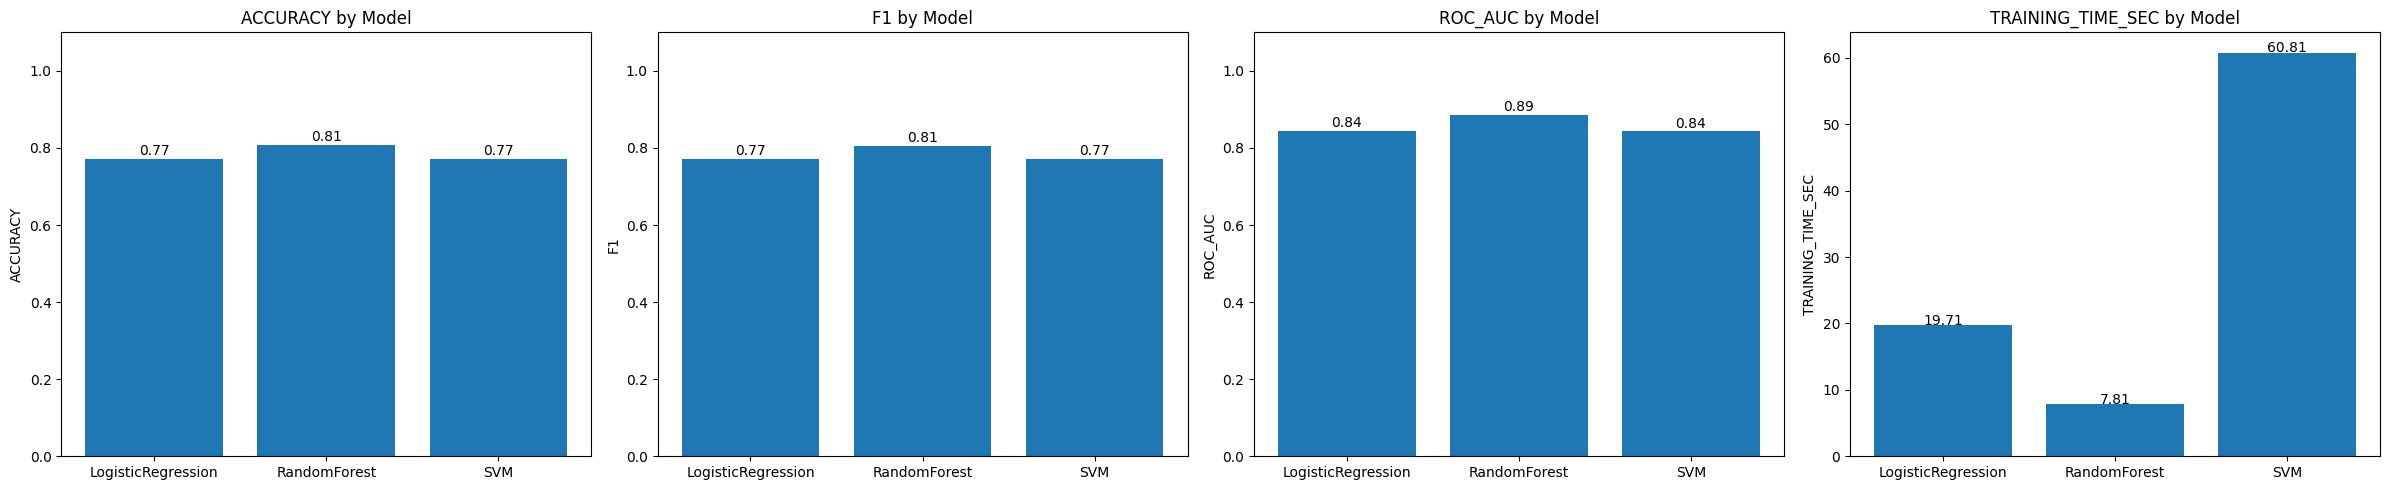

In [ ]:
# Plot Grafik Evaluasi
import matplotlib.pyplot as plt

metrics_to_plot = ["accuracy", "f1", "roc_auc", "training_time_sec"]
fig, axes = plt.subplots(1, 4, figsize=(24, 5))

for i, metric in enumerate(metrics_to_plot):
    axes[i].bar(df_eval["Model"], df_eval[metric])
    axes[i].set_title(f"{metric.upper()} by Model")
    axes[i].set_ylim(0, 1.1 if 'time' not in metric else None)
    axes[i].set_ylabel(metric.upper())
    for idx, val in enumerate(df_eval[metric]):
        axes[i].text(idx, val + 0.01, f"{val:.2f}", ha='center')

plt.tight_layout()
plt.show()